In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [53]:

darkrate_df = pd.read_csv('PMT4_DR_polya_peak_positions.csv')

darkrate_df = darkrate_df[darkrate_df['polya_peak_pC'] > 0].reset_index(drop=True)

print('DARKRATE')
print(darkrate_df)

DARKRATE
    voltage  polya_peak_pC  polya_peak_error_pC
0      1750       0.701098             0.000495
1      1750       0.692231             0.000235
2      1750       0.705558             0.000156
3      1800       0.864492             0.000166
4      1800       0.865817             0.000131
5      1800       0.869064             0.000152
6      1800       0.859808             0.000199
7      1800       0.868153             0.000172
8      1800       0.870119             0.000223
9      1850       1.042464             0.000386
10     1850       1.027286             0.003001
11     1850       1.055333             0.002922
12     1850       1.070528             0.001609
13     1850       1.033759             0.000591
14     1900       1.310885             0.000670
15     1900       1.304097             0.000510
16     1900       1.283013             0.001183
17     1900       1.317435             0.000642
18     1900       1.309425             0.000665
19     1900       1.322362     

In [54]:
#add gain columns to the data frames

def add_gain_columns(df):
    df=df.copy()
    df['gain'] = (df['polya_peak_pC']*(1e-12)/(1.6e-19))
    df['gain_error'] = (df['polya_peak_error_pC']*(1e-12)/(1.6e-19))
    return df

darkrate_df = add_gain_columns(darkrate_df)

In [55]:
#find mean gain for each voltage in case of multiple trials

def average_gain_per_voltage(df):
    grouped = df.groupby('voltage')
    mean_gain = grouped['gain'].mean()
    mean_gain_err = grouped['gain_error'].apply(lambda errs: np.sqrt(np.sum(errs**2)) / len(errs)
    )
    
    out = pd.DataFrame({'voltage': mean_gain.index,
        'gain': mean_gain.values,
        'gain_error': mean_gain_err.values})
    
    return out.sort_values('voltage')

darkrate_avg_gain = average_gain_per_voltage(darkrate_df)
print(darkrate_avg_gain)

   voltage          gain    gain_error
0     1750  4.372683e+06   1186.672739
1     1800  5.414014e+06    450.405777
2     1850  6.536712e+06   5677.840996
3     1900  8.174183e+06   1973.388033
4     1950  1.090250e+07   4193.070587
5     2000  8.494694e+06  23707.916683


In [56]:
#gain model and fitting
def gain_model(V, A, B):
    return A * V**(14 * B)

def fit_gain_curve(voltage, gain, gain_err):
    p0 = [1e-29, 0.7] #initial guesses
    '''
    bounds = (
        [1e-30, 0.6],   # lower bounds: A, B
        [1e-25, 0.9]    # upper bounds: A, B
    )
    popt, pcov = curve_fit(
        gain_model,
        voltage,
        gain,
        sigma=gain_err,
        absolute_sigma=True,
        p0=p0,
        bounds=bounds,
        maxfev=10000
    )
    '''
    popt, pcov = curve_fit(
        gain_model,
        voltage,
        gain,
        sigma=gain_err,
        absolute_sigma=True,
        p0=p0,
        maxfev=10000
    )

    A_fit, B_fit = popt
    err_A, err_B = np.sqrt(np.diag(pcov))

    return A_fit, B_fit, err_A, err_B



A_dark, B_dark, errA_dark, errB_dark = fit_gain_curve(
    darkrate_avg_gain['voltage'].values,
    darkrate_avg_gain['gain'].values,
    darkrate_avg_gain['gain_error'].values,
)


V_plot = np.linspace(darkrate_avg_gain['voltage'].min(),darkrate_avg_gain['voltage'].max(),300)


/var/folders/54/shy8r4g15d33hf9px0m5hytc0000gn/T/ipykernel_56342/1491268487.py:3: RuntimeWarning: overflow encountered in power
  return A * V**(14 * B)


In [57]:
#compute chi squareds

def chi_squared(y_data, y_model, y_err, n_params):
    chi2 = np.sum(((y_data-y_model)/y_err)**2)
    dof = len(y_data)-n_params
    chi2_reduced = chi2/dof
    return chi2, chi2_reduced

y_dark_model = gain_model(darkrate_avg_gain['voltage'].values,A_dark,B_dark)
chi2_dark, chi2_red_dark = chi_squared(
    darkrate_avg_gain['gain'].values,
    y_dark_model,
    darkrate_avg_gain['gain_error'].values,
    n_params=2
)

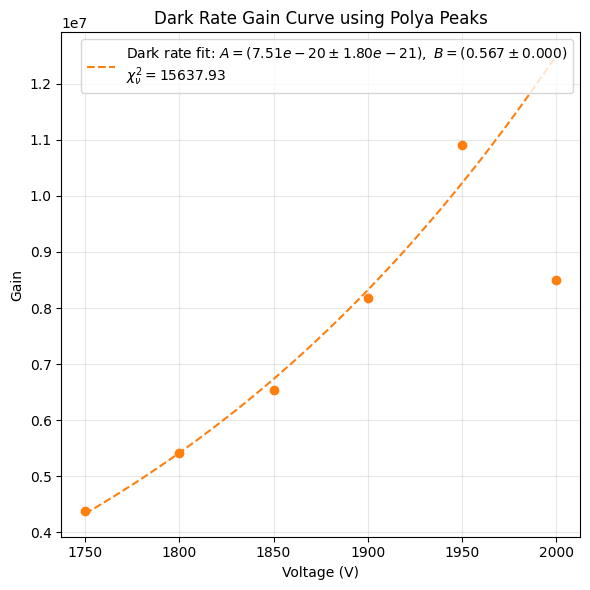

In [58]:

plt.figure(figsize=(6, 6))
plt.errorbar(darkrate_avg_gain['voltage'],darkrate_avg_gain['gain'],yerr=darkrate_avg_gain['gain_error'],fmt='o',color='tab:orange', capsize=3)
plt.plot(V_plot,gain_model(V_plot, A_dark, B_dark),'--',color='tab:orange',label=(
        rf'Dark rate fit: $A=({A_dark:.2e}\pm{errA_dark:.2e}),\ B=({B_dark:.3f}\pm{errB_dark:.3f})$'
        + f'\n$\\chi^2_\\nu={chi2_red_dark:.2f}$'
    ))
plt.xlabel('Voltage (V)')
plt.ylabel('Gain')
plt.title('Dark Rate Gain Curve using Polya Peaks')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()